# Automating Flow Cytometry Data Analysis

**USD M.Sc. Applied Data Science Capstone Project** \
*Shiley-Marcos School of Engineering* \


Gabriella Rivera\
John Vincent Deniega \
Date: 7Nov2024 \


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vanguardfox/ADS599/blob/main/ADS599.ipynb)

Mount Google Drive

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Install packages:

In [2]:
#!pip install FlowCal
#!pip install flowio
#!pip install openTSNE
#!pip install umap-learn

Import libraries:

In [3]:
import FlowCal
import flowio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import pandas as pd
import seaborn as sns
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
import umap
import matplotlib.ticker as ticker

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

Handle Warnings

In [4]:
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

Selected cellular surface markers to identify target Dendritic Cells (DC): Myeloid DC and Plasmacytoid DC.

| Marker | Fluorochrome | Description |
|--------|--------------|--------------|
| CD45RA | Ax700 | An isoform of CD45, marking naïve T cells that haven't encountered their antigen
| HLA-DR | BV786 | An MHC class II molecule presenting antigens to CD4+ T cells; indicates antigen-presenting cells (APCs)
| CD3 | APC-H7 | Part of the T-cell receptor complex, essential for T cell activation; found on all T cells
| CD20 | BUV805 | A B cell marker involved in activation and proliferation; used to identify B cells
| CD19 | PE-Cy5 | A co-receptor for B cell activation, primarily expressed on B cells
| CD14 | BV510 | A co-receptor for LPS, marking monocytes and macrophages involved in innate immunity
| CD123 | BB660 | The alpha chain of the IL-3 receptor, found on plasmacytoid dendritic cells and progenitor cells
| CD11c | APC | An integrin marking dendritic cells and certain macrophages, important for cell adhesion and activation

**Cellular Pathway:**

1. *PBMCs (Peripheral Blood Mononuclear Cells)* \
   Starting population

2. *CD3-* \
   Excludes T cells, focusing on B cells and myeloid cells

3. *CD19- & CD20-*  \
   Excludes B cells, narrowing down to monocytes and dendritic cells

4. *CD14-*  \
   Further excludes monocytes, leading to dendritic cell populations

5. *HLA-DR+*  \
   Identifies antigen-presenting cells (APC)

6. *CD11c+ (Myeloid DC)*  \
   Indicates myeloid dendritic cells  \

  **OR**
   
   *CD123+ (Plasmacytoid DC)*   \
   Indicates plasmacytoid dendritic cells


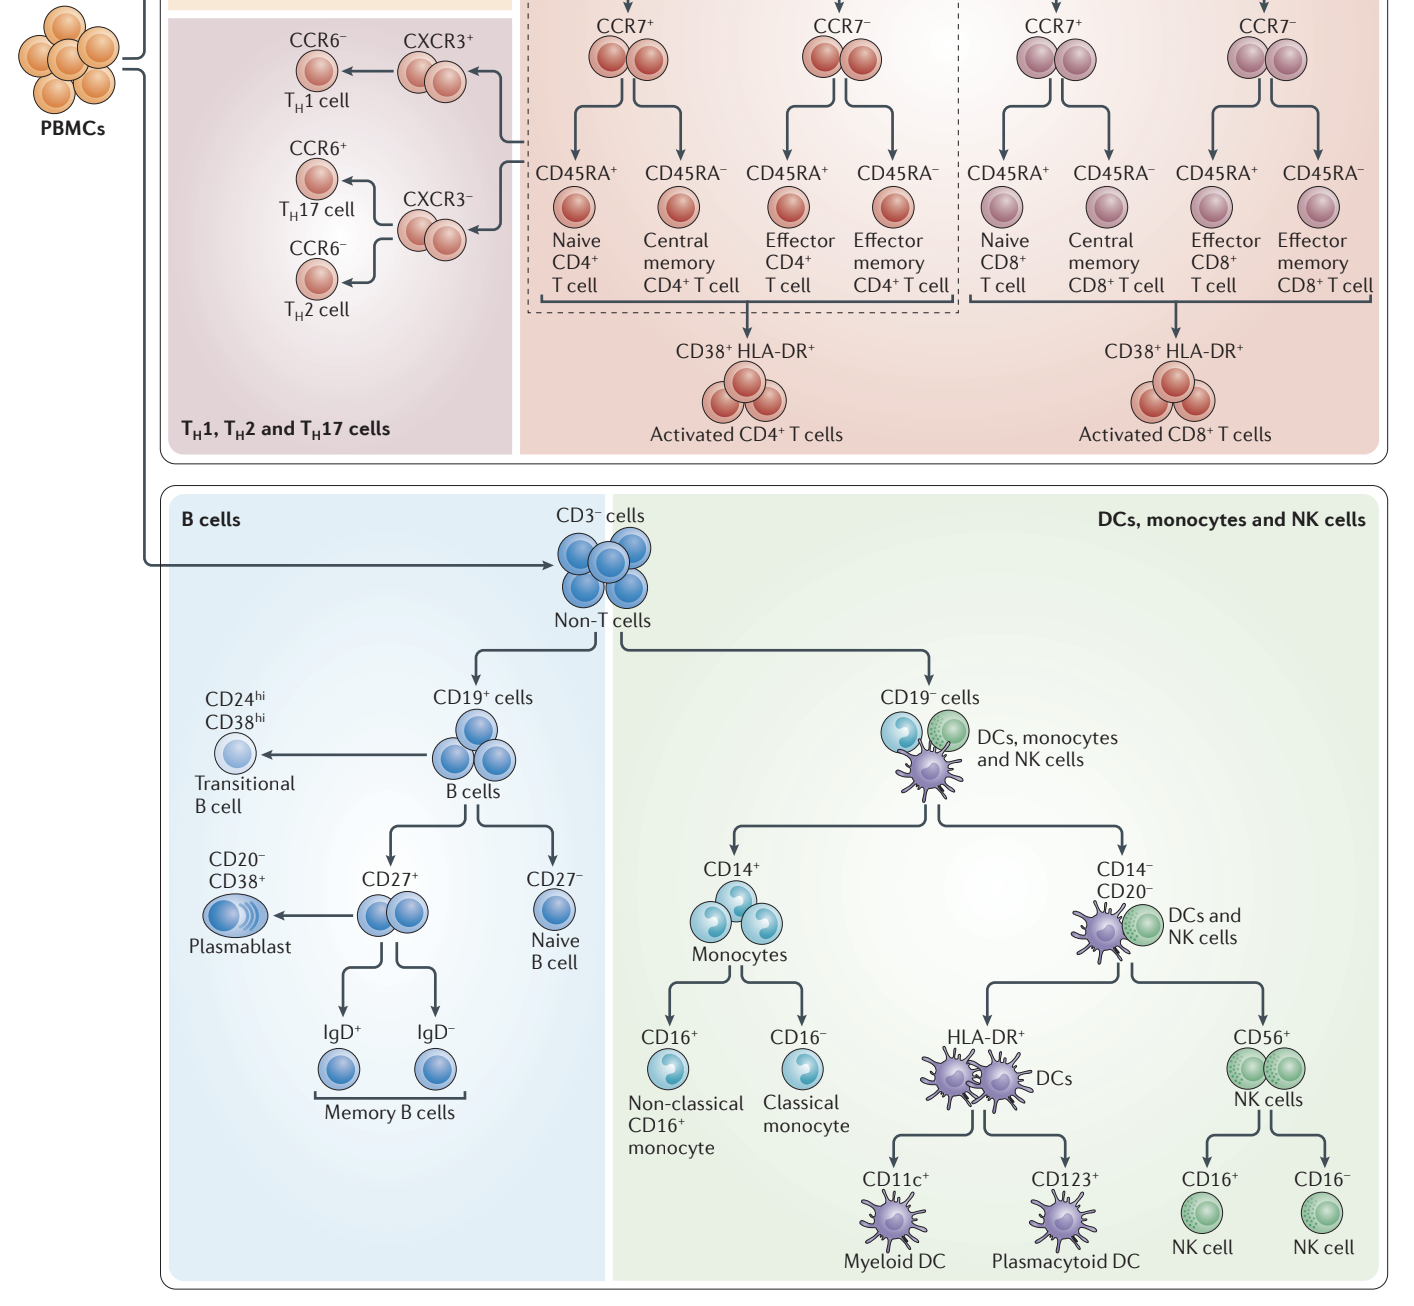

## Flow Cytometry Data Extraction

Import datasets:

In [5]:
# User's MyDrive paths
#JV = "/content/drive/MyDrive/Colab_Notebooks/ADS599"
GR = "/content/drive/MyDrive/DC Marker Files/FCS"

# Only for JV's local execution
# Define the paths dynamically
home_dir = os.path.expanduser("~")
# Change the words after home_dir to reflect your local location/directories for the FCS files
JV = os.path.join(home_dir, 
                          "Desktop", 
                          "usd_ADS", 
                          "ADS599", 
                          "Notebook", 
                          "FlowRepository_FR-FCM-Z32U_files")

In [6]:
# Define the path to the FCS file
fcs_folder = JV
pbmc_file = "PBMC_090120_1_DCs_A5_A05_031.fcs"
pbmc_path = os.path.join(fcs_folder, pbmc_file)
save_folder = JV

# Load the FCS data into an object
pbmc = FlowCal.io.FCSData(pbmc_path)

# Inspect available attributes
print("Available attributes of FCSData:")
for attr in dir(pbmc):
    if not attr.startswith('_'):
        print(attr)

Available attributes of FCSData:
T
acquisition_end_time
acquisition_start_time
acquisition_time
all
amplification_type
amplifier_gain
analysis
any
argmax
argmin
argpartition
argsort
astype
base
byteswap
channel_labels
channels
choose
clip
compress
conj
conjugate
copy
ctypes
cumprod
cumsum
data
data_type
detector_voltage
diagonal
dot
dtype
dump
dumps
fill
flags
flat
flatten
getfield
hist_bins
imag
infile
item
itemset
itemsize
max
mean
min
nbytes
ndim
newbyteorder
nonzero
partition
prod
ptp
put
range
ravel
real
repeat
reshape
resize
resolution
round
searchsorted
setfield
setflags
shape
size
sort
squeeze
std
strides
sum
swapaxes
take
text
time_step
tobytes
tofile
tolist
tostring
trace
transpose
var
view


In [7]:
# Access the channel labels by calling the method
marker_labels = pbmc.channel_labels()

# Print the marker labels
print("Marker Labels:", marker_labels)

Marker Labels: [None, None, None, 'CADM1 FITC', 'CD141 BB630', 'CD123 BB660', 'FcER1a BB700', None, 'XCR1 BV421', 'CD14 BV510', 'CD16 BV570', None, 'CD172a BV650', None, 'CD303 BV750', 'HLA-DR BV786', 'CD1c BUV395', 'Live Dead UV Blue', None, 'CD56 BUV563', 'CD89 BUV661', 'CD163 BUV737', 'CD20 BUV805', 'CD11c APC', 'CD45RA Ax700', 'CD3 APC-H7', 'CD301 PE', None, 'CD19 PE-Cy5', 'CD5 PE-Cy55', 'CD88 PE-Cy7', None]


In [8]:
# Convert pbmc to little-endian float32
if pbmc.dtype != '<f4':
    pbmc = np.array(pbmc, dtype='<f4')

# Replace the first three column labels with specified values
marker_labels[0] = "FSC-A"
marker_labels[1] = "FSC-H"
marker_labels[2] = "SSC-A"
marker_labels[31] = "Time"

# Convert the FCS data to a Pandas DataFrame
pbmc_s1_df = pd.DataFrame(pbmc)

# Assign marker labels to the DataFrame columns
pbmc_s1_df.columns = marker_labels

# Extract the 'Time' data and scale it
pbmc_s1_df['Time'] = pbmc_s1_df['Time'] * 0.01

# Convert all columns to float32 (little-endian), except 'Time'
numeric_columns = pbmc_s1_df.columns.difference(['Time'])

# Use astype to convert and force little-endian byte order for numeric columns
pbmc_s1_df[numeric_columns] = pbmc_s1_df[numeric_columns].astype('<f4')

# Save the formatted DataFrame as a CSV file
output_file = "pbmc_s1.csv"

# Uncomment this for Google Colab
#save_folder = "/content"

# Uncomment this for local JV execution
save_folder = os.path.join(home_dir, 
                          "Desktop", 
                          "usd_ADS", 
                          "ADS599", 
                          "Notebook", 
                          "content")

output_path = os.path.join(save_folder, output_file)
pbmc_s1_df.to_csv(output_path, index=False)

## Data Preprocessing or Data Wrangling

In [9]:
# Uncomment if using Google Colab
# Upload Dataset from Google Drive
#pbmc_s1_df = pd.read_csv("pbmc_s1.csv")

# Uncomment if using local JV instance
pbmc_s1_df = pd.read_csv(os.path.join(save_folder, output_file))

# Round all columns to 3 decimal places
pbmc_s1_df = pbmc_s1_df.round(4)

# Display the shape of the DataFrame
print("Number of Original instances and features:", pbmc_s1_df.shape)

Number of Original instances and features: (2088689, 32)


In [10]:
pbmc_s1_df.head()

,FSC-A,FSC-H,SSC-A,CADM1 FITC,CD141 BB630,CD123 BB660,FcER1a BB700,Unnamed: 7,XCR1 BV421,CD14 BV510,...,CD20 BUV805,CD11c APC,CD45RA Ax700,CD3 APC-H7,CD301 PE,Unnamed: 27,CD19 PE-Cy5,CD5 PE-Cy55,CD88 PE-Cy7,Time
0,87361.875,79434.130,598.2787,160.1808,59.9483,265.0523,2209.8892,618.3924,86.7269,135.5125,...,263.7383,134.7742,2193.2383,1619.1234,502.2087,186.3623,161.5814,3681.0247,3134.7780,0.0364
1,126908.380,108476.130,1030.2587,202.5917,1682.3060,2094.6912,4600.4336,1695.1306,1039.5717,1021.7797,...,1318.8644,1797.3150,3525.5068,677.8574,5200.4470,3191.4165,642.0549,2521.5664,2330.8674,0.0364
2,80773.440,72883.586,460.6992,63.8090,41.5123,187.3313,1758.5116,564.4677,85.9101,132.6208,...,163.5142,136.5762,2556.1055,1337.7683,291.1574,116.8086,78.4026,3396.2102,2594.3127,0.0367
3,98579.290,90491.320,798.3377,180.5725,584.3997,4503.6934,10570.9375,4350.1704,1614.7689,780.5013,...,487.6752,2861.1963,4038.2563,650.1272,547.4395,503.1614,774.6176,3809.5645,5784.4300,0.0369
4,81687.250,74994.590,586.4979,156.9436,-2.7428,89.6369,1083.4099,343.4184,75.9819,173.5936,...,174.4891,77.2289,3129.6992,1420.8434,196.8091,97.8045,122.2280,2326.3208,2200.1838,0.0372


In [11]:
# Remove unnamed columns
pbmc_s1_df = pbmc_s1_df.loc[:, ~pbmc_s1_df.columns.str.contains('^Unnamed')]

# Display the shape of the DataFrame after filtering
print("Number of instances and features after filtering:", pbmc_s1_df.shape)

Number of instances and features after filtering: (2088689, 27)


In [12]:
# Remove unnecessary features
pbmc_s1_df = pbmc_s1_df.drop(columns=['CADM1 FITC', 'CD141 BB630', 'FcER1a BB700',
                                      'XCR1 BV421', 'CD16 BV570', 'CD172a BV650',
                                      'CD303 BV750', 'CD1c BUV395', 'CD56 BUV563',
                                      'CD89 BUV661', 'CD163 BUV737', 'CD301 PE',
                                      'CD5 PE-Cy55', 'CD88 PE-Cy7'])

# Display the shape of the DataFrame after filtering
print("Number of instances  and features after filtering:", pbmc_s1_df.shape)

Number of instances  and features after filtering: (2088689, 13)


In [13]:
# Remove instances where Time is gated
pbmc_s1_df = pbmc_s1_df[(pbmc_s1_df['Time'] > 3) &
                        (pbmc_s1_df['Time'] < 215)
                        ]

# Display the shape of the DataFrame after filtering
print("Number of instances after filtering:", pbmc_s1_df.shape[0])

Number of instances after filtering: 2035056


In [14]:
# Remove instances where FSC is at a certain threshold
pbmc_s1_df = pbmc_s1_df[(pbmc_s1_df['FSC-A'] > 20000) &
                        (pbmc_s1_df['FSC-H'] < 200000) &
                        (pbmc_s1_df['FSC-A'] < 550000)
                        ]

# Display the shape of the DataFrame after filtering
print("Number of instances after filtering:", pbmc_s1_df.shape[0])

Number of instances after filtering: 1958049


In [15]:
# Remove instances where SSC is at a certain threshold
pbmc_s1_df = pbmc_s1_df[(pbmc_s1_df['SSC-A'] > 110) &
                         (pbmc_s1_df['SSC-A'] < 20000)
                         ]

# Display the shape of the DataFrame after filtering
print("Number of instances after filtering:", pbmc_s1_df.shape[0])

Number of instances after filtering: 1956288


In [16]:
# Remove instances where Live Dead UV Blue is below a certain threshold
pbmc_s1_df = pbmc_s1_df[(pbmc_s1_df['Live Dead UV Blue'] < 700)]

# Display the shape of the DataFrame after filtering
print("Number of instances after filtering:", pbmc_s1_df.shape[0])

Number of instances after filtering: 1260083


In [17]:
# Save the formatted DataFrame as a CSV file
output_file = "pbmc_clean.csv"
output_path = os.path.join(save_folder, output_file)
pbmc_s1_df.to_csv(output_path, index=False)

## Exploratory Data Analysis

## Training, Validation, and Test Data sets

**Cleaned data sets to be used for Model Development and Testings**

In [18]:
# Upload Dataset from Google Drive
pbmc_clean = pd.read_csv(output_path)

# Display the shape of the DataFrame
print("Number of instances and features:", pbmc_clean.shape)

Number of instances and features: (1260083, 13)


In [19]:
# Split the dataset into training + validation and test sets
train_val, test = train_test_split(pbmc_clean, test_size=0.2, random_state=42)  # 20% for test

# Now split the training + validation set into training and validation sets
train, val = train_test_split(train_val, test_size=0.25, random_state=42)       # 25% of 80% is 20%

# - train: 60% of the original data
# - val: 20% of the original data
# - test: 20% of the original data

## Reduce Dimensionality

### PCA (Principal Component Analysis) - Most basic

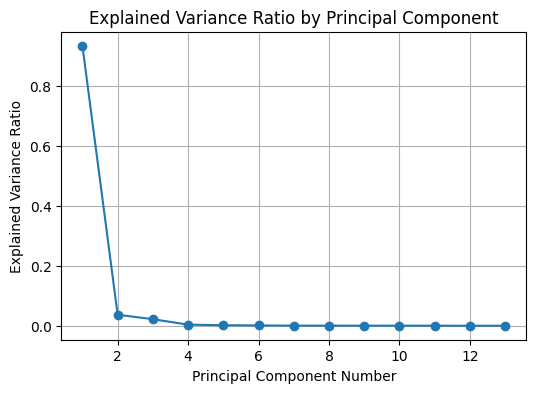

In [20]:
# Fit PCA on the training data
pca = PCA().fit(train)

# Plot the explained variance ratio
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_, marker='o')
plt.title('Explained Variance Ratio by Principal Component')
plt.xlabel('Principal Component Number')
plt.ylabel('Explained Variance Ratio')
plt.grid()
plt.show()

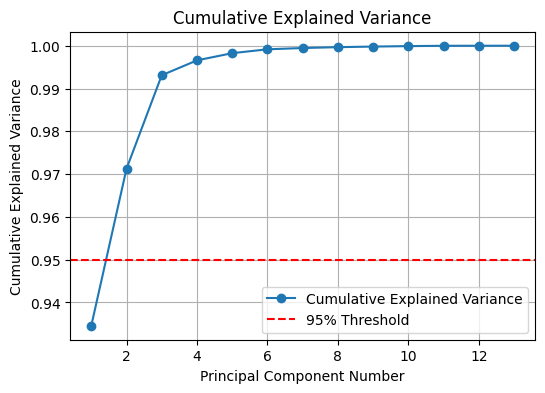

In [21]:
# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(cumulative_variance) + 1),
         cumulative_variance,
         marker='o',
         label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component Number')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid()
plt.show()

PCA Train, Val, and Test Dataframes

In [22]:
# Perform PCA with 3 components
pca = PCA(n_components=3)
train_pca = pca.fit_transform(train)
val_pca = pca.transform(val)
test_pca = pca.transform(test)

# Convert PCA results to DataFrame for easier plotting
train_pca_df = pd.DataFrame(data=train_pca, columns=['PC1', 'PC2','PC3'])
val_pca_df = pd.DataFrame(data=val_pca, columns=['PC1', 'PC2', 'PC3'])
test_pca_df = pd.DataFrame(data=test_pca, columns=['PC1', 'PC2', 'PC3'])

In [23]:
# Combine the data into one DataFrame for easy plotting
#train_pca_df['Set'] = 'Training set'
#val_pca_df['Set'] = 'Validation set'
#test_pca_df['Set'] = 'Test set'

# Sample random points from the combined dataset for visualization
#sampled_df = train_pca_df.sample(n=500000, random_state=42)

# Create the interactive 3D plot with the sampled data
#fig = px.scatter_3d(sampled_df, x='PC1', y='PC2', z='PC3', color = 'PC3',
#                    labels={'PC1': 'PC 1',
#                            'PC2': 'PC 2',
#                            'PC3': 'PC 3'},
#                    title='Training Set: PCA of Flow Cytometry Data')

# Show the plot
#fig.show()

## Model Development

### Try openTSNE (Optimized for larger datasets)
#### perplexity=10 @ 8m 44s

In [24]:
from openTSNE import TSNE # Import here rather than earlier since TSNE has conflict above

### Model 1 - Gaussian Mixture Model

In [25]:
open_tsne = TSNE(n_components=2, perplexity=30, n_jobs=-1, random_state=42)

sample_size = 100000

train_tsne = open_tsne.fit(train_pca[:sample_size])
val_tsne = open_tsne.fit(val_pca[:sample_size])
test_tsne = open_tsne.fit(test_pca[:sample_size])

train_tsne_df = pd.DataFrame(train_tsne, columns=['TSNE1', 'TSNE2'])
val_tsne_df = pd.DataFrame(val_tsne, columns=['TSNE1', 'TSNE2'])
test_tsne_df = pd.DataFrame(test_tsne, columns=['TSNE1', 'TSNE2'])

In [26]:
cluster_count = 5
gmm = GaussianMixture(n_components=cluster_count, random_state=42)
gmm_labels = gmm.fit_predict(train_tsne_df[['TSNE1', 'TSNE2']])

train_tsne_df['Cluster'] = gmm_labels

# Reset index of train set to for merging
train_reset = train.reset_index(drop=True)

# Merge the original training set data with the t-SNE cluster labels
train_with_clusters = pd.concat([train_reset, train_tsne_df[['Cluster']]], axis=1)

In [27]:
pbmc_s1_df.columns

Index(['FSC-A', 'FSC-H', 'SSC-A', 'CD123 BB660', 'CD14 BV510', 'HLA-DR BV786',
       'Live Dead UV Blue', 'CD20 BUV805', 'CD11c APC', 'CD45RA Ax700',
       'CD3 APC-H7', 'CD19 PE-Cy5', 'Time'],
      dtype='object')

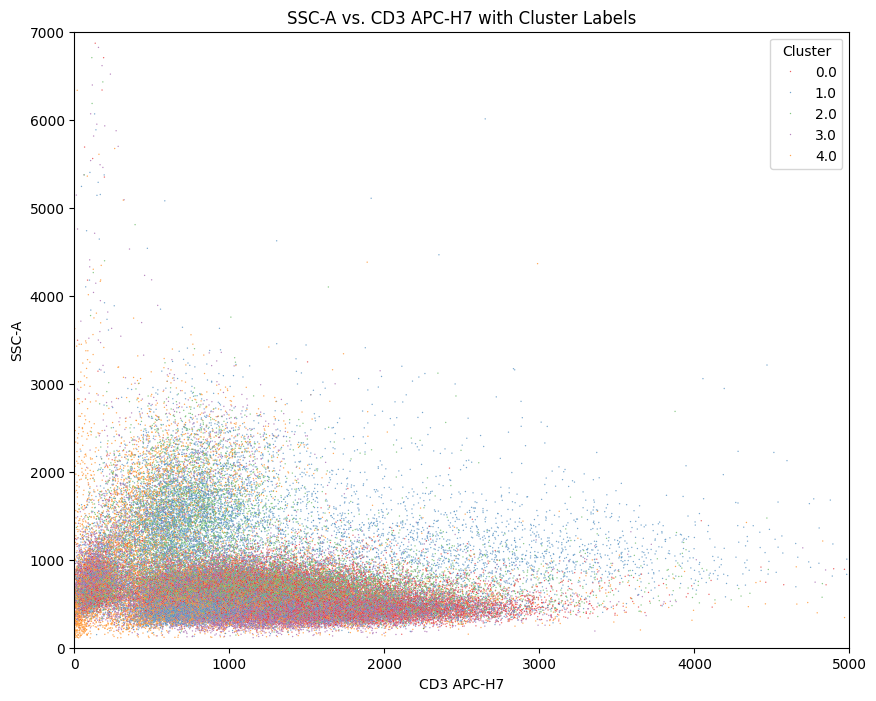

In [44]:
# Reset index of train set to for merging
train_reset = train.reset_index(drop=True)

# Merge the original training set data with the t-SNE cluster labels
train_with_clusters = pd.concat([train_reset, train_tsne_df[['Cluster']]], axis=1)

# Plot "SSC-A" vs. "CD3 APC-H7" colored by cluster
plt.figure(figsize=(10, 8))
sns.scatterplot(data=train_with_clusters,
                x='CD3 APC-H7', 
                y='SSC-A', 
                hue='Cluster', 
                palette='Set1', 
                s=1, 
                alpha=0.7
)

plt.xlabel("CD3 APC-H7")
plt.ylabel("SSC-A")
plt.xlim(0, 5000)
plt.ylim(0, 7000)
plt.title("SSC-A vs. CD3 APC-H7 with Cluster Labels")
plt.legend(title="Cluster", loc='best')
plt.show()

In [29]:
cluster0 = train_with_clusters[train_with_clusters['Cluster']==0.0]
cluster1 = train_with_clusters[train_with_clusters['Cluster']==1.0]
cluster2 = train_with_clusters[train_with_clusters['Cluster']==2.0]
cluster3 = train_with_clusters[train_with_clusters['Cluster']==3.0]
cluster4 = train_with_clusters[train_with_clusters['Cluster']==4.0]
cluster5 = train_with_clusters[train_with_clusters['Cluster']==5.0]
cluster6 = train_with_clusters[train_with_clusters['Cluster']==6.0]

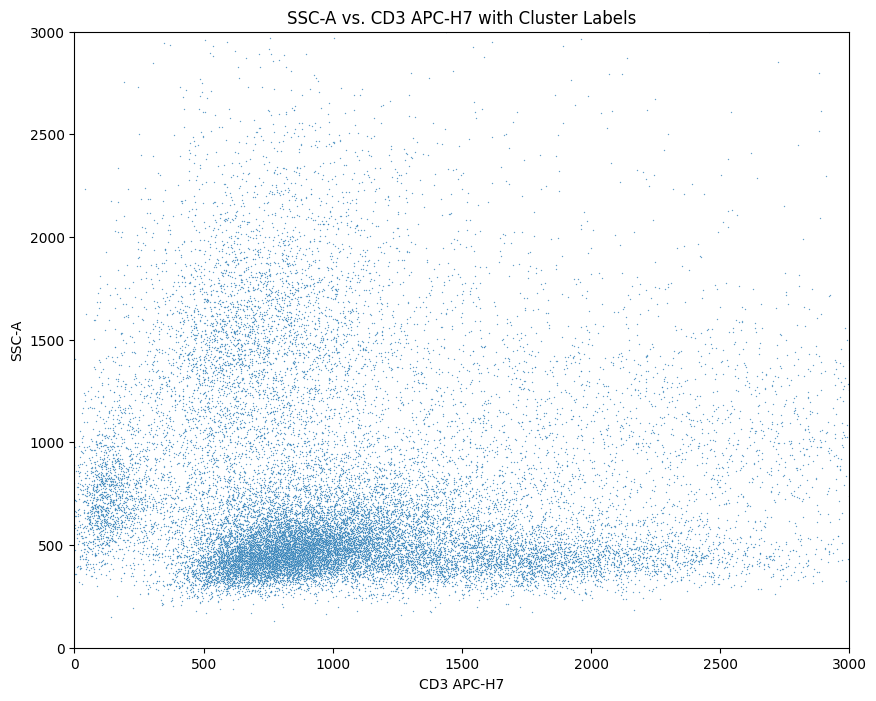

In [39]:
# Plot "SSC-A" vs. "CD3 APC-H7" colored by cluster
plt.figure(figsize=(10, 8))
sns.scatterplot(data=cluster1,
                x='CD3 APC-H7', 
                y='SSC-A', 
                palette='Set1', 
                s=1, 
                alpha=0.7
)

plt.xlabel("CD3 APC-H7")
plt.ylabel("SSC-A")
plt.xlim(0, 3000)
plt.ylim(0, 3000)
plt.title("SSC-A vs. CD3 APC-H7 with Cluster Labels")
plt.show()

In [31]:
cluster0 = cluster0.drop('Cluster', axis=1, inplace=True)

In [41]:
cluster1.head()

,FSC-A,FSC-H,SSC-A,CD123 BB660,CD14 BV510,HLA-DR BV786,Live Dead UV Blue,CD20 BUV805,CD11c APC,CD45RA Ax700,CD3 APC-H7,CD19 PE-Cy5,Time,Cluster
4,161110.940,83526.15,834.9262,240.9422,222.4482,1811.1492,381.8828,510.5118,191.6737,3966.1230,4188.8910,202.5607,190.9942,1.0
8,62646.973,57678.83,499.3855,194.3904,141.3488,944.4211,182.2575,575.3004,139.3981,3215.3796,2649.0800,86.9875,16.6483,1.0
9,71670.150,64932.84,713.6741,146.6056,206.0998,209.8639,185.1683,22.0208,50.0779,1756.5591,587.1951,197.6788,166.2274,1.0
11,64092.730,56227.94,971.4736,125.4979,274.4529,709.7242,277.8881,219.0292,528.5879,2164.8132,1396.4130,157.2733,133.0391,1.0
12,71718.050,65861.58,302.3079,8404.7110,277.9987,12199.2240,322.7217,3679.0576,1768.0796,1517.8704,721.3344,5068.1396,40.6251,1.0


In [43]:
# Perform PCA with 3 components

pca = PCA(n_components=3)
filtered_pca = pca.fit_transform(cluster1)

# Convert PCA results to DataFrame for easier plotting
filtered_pca_df = pd.DataFrame(data=filtered_pca, columns=['PC1', 'PC2','PC3'])

open_tsne = TSNE(n_components=2, perplexity=50, n_jobs=-1, random_state=42)


tsne = open_tsne.fit(train_pca)
tsne_df = pd.DataFrame(train_tsne, columns=['TSNE1', 'TSNE2'])



cluster_count = 3
gmm_filtered = GaussianMixture(n_components=cluster_count, random_state=42)
gmm_filtered_labels = gmm_filtered.fit_predict(train_tsne_df[['TSNE1', 'TSNE2']])

train_tsne_df['Cluster'] = gmm_labels

# Reset index of train set to for merging
train_reset = train.reset_index(drop=True)

# Merge the original training set data with the t-SNE cluster labels
train_with_clusters = pd.concat([train_reset, train_tsne_df[['Cluster']]], axis=1)

In [ ]:
# Calculate x_gate and y_gate based on cluster means in the original dimensions like with labels
cluster_means = (
    train_with_clusters.groupby('Cluster')[['CD3 APC-H7', 'CD19 PE-Cy5']].mean()
)

x_gate = cluster_means['CD3 APC-H7'].mean()  # Dynamic gate for CD3 APC-H7
y_gate = cluster_means['CD19 PE-Cy5'].mean()  # Dynamic gate for CD19 PE-Cy5

print(f"x_gate: {x_gate}, y_gate: {y_gate}")

In [ ]:
# Plot "CD19 PE-Cy5" vs. "CD3 APC-H7" colored by cluster
plt.figure(figsize=(10, 8))

sns.scatterplot(data=train_with_clusters,
                x='CD3 APC-H7', 
                y='CD19 PE-Cy5', 
                hue='Cluster', 
                palette='viridis', 
                s=10, 
                alpha=0.7)

# Add gates as dashed lines
plt.axvline(x=x_gate, color='black', linestyle='--', label=f'x_gate: {x_gate:.2f}')
plt.axhline(y=y_gate, color='black', linestyle='--', label=f'y_gate: {y_gate:.2f}')
# Set logarithmic scale
plt.xscale('log')
plt.yscale('log')

# Set tick marks at every power of 10
ax = plt.gca()  # Get the current axis
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0))
ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0))

plt.xlim(1, 100000)  # Ensure the range starts at 1 (log cannot be zero)
plt.ylim(1, 100000)

plt.xlabel("CD3 APC-H7")
plt.ylabel("CD19 PE-Cy5")
plt.title("CD19 PE-Cy5 vs. CD3 APC-H7 with Cluster Labels and Gates")
plt.legend(title="Cluster", loc='best')
plt.show()

In [ ]:
# Define the function to assign names based on quadrant logic
def assign_cluster_label(x, y, x_gate, y_gate, x_label, y_label):
    if x > x_gate and y > y_gate:
        return f"{x_label} +, {y_label} +"  # Q2
    elif x <= x_gate and y > y_gate:
        return f"{y_label} +"  # Q1
    elif x > x_gate and y <= y_gate:
        return f"{x_label} +"  # Q3
    elif x <= x_gate and y <= y_gate:
        return f"{x_label} -, {y_label} -"  # Q4
    else:
        return "Unassigned"  # Handles edge cases (if any)

# Label centroids by their quadrant location
centroids['Cluster Label'] = centroids.apply(
    lambda row: assign_cluster_label(
        row['CD3 APC-H7'], 
        row['CD19 PE-Cy5'], 
        x_gate, 
        y_gate, 
        "CD3 APC-H7", 
        "CD19 PE-Cy5"
    ),
    axis=1
)

# Map cluster IDs to descriptive labels
cluster_labels = {row['Cluster']: f"Cluster {int(row['Cluster'])} ({row['Cluster Label']})" for _, row in centroids.iterrows()}

# Update the labels in the DataFrame to use for dotplotting
train_with_clusters['Cluster Label'] = train_with_clusters['Cluster'].map(cluster_labels)

# Plot "CD19 PE-Cy5" vs. "CD3 APC-H7" colored by updated cluster labels
plt.figure(figsize=(10, 8))
sns.scatterplot(data=train_with_clusters,
                x='CD3 APC-H7', 
                y='CD19 PE-Cy5', 
                hue='Cluster Label', 
                palette='Set1', 
                s=10, 
                alpha=0.7)

# Add gates as dashed lines
plt.axvline(x=x_gate, color='black', linestyle='--', label=f'x_gate: {x_gate:.2f}')
plt.axhline(y=y_gate, color='black', linestyle='--', label=f'y_gate: {y_gate:.2f}')

# Set logarithmic scale
plt.xscale('log')
plt.yscale('log')

# Set tick marks at every power of 10
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0))
ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0))

plt.xlim(1, 100000)
plt.ylim(1, 100000)
plt.xlabel("CD3 APC-H7")
plt.ylabel("CD19 PE-Cy5")
plt.title("CD19 PE-Cy5 vs. CD3 APC-H7 with Cluster Labels")
plt.legend(title="Cluster and Gates", loc='best')
plt.show()

In [ ]:
# Define quadrants based on gates
conditions = [
    (train_with_clusters['CD3 APC-H7'] > x_gate) & (train_with_clusters['CD19 PE-Cy5'] > y_gate),  # Q1
    (train_with_clusters['CD3 APC-H7'] <= x_gate) & (train_with_clusters['CD19 PE-Cy5'] > y_gate),  # Q2
    (train_with_clusters['CD3 APC-H7'] > x_gate) & (train_with_clusters['CD19 PE-Cy5'] <= y_gate),  # Q3
    (train_with_clusters['CD3 APC-H7'] <= x_gate) & (train_with_clusters['CD19 PE-Cy5'] <= y_gate),  # Q4
]
quadrant_labels = ['Q1', 'Q2', 'Q3', 'Q4']

# Assign each point a quadrant label
train_with_clusters['Quadrant'] = np.select(conditions, quadrant_labels, default='Unclassified')

# Check the quadrant assignment
print(train_with_clusters[['CD3 APC-H7', 'CD19 PE-Cy5', 'Cluster', 'Quadrant']].head())


### UMAP (Uniform Manifold Approximation and Projection) - Alternative to T-SNE, after passing through PCA

In [ ]:
# Perform UMAP with 3 components
umap_model = umap.UMAP(n_components=3, n_jobs=-1)
train_umap = umap_model.fit_transform(train_pca)
val_umap = umap_model.fit_transform(val_pca)
test_umap = umap_model.fit_transform(test_pca)

# Convert UMAP results to DataFrame for easier plotting
train_umap_df = pd.DataFrame(train_umap, columns=['UMAP1', 'UMAP2', 'UMAP3'])
val_umap_df = pd.DataFrame(val_umap, columns=['UMAP1', 'UMAP2', 'UMAP3'])
test_umap_df = pd.DataFrame(test_umap, columns=['UMAP1', 'UMAP2', 'UMAP3'])

In [ ]:
# Sample random points from the combined dataset for visualization
sampled_df = train_umap_df.sample(n=500000, random_state=42)

# Create the interactive 3D plot with the sampled data
fig = px.scatter_3d(sampled_df, x='UMAP1', y='UMAP2', z='UMAP3', color = 'UMAP1',
                    labels={'UMAP1': 'UMAP 1',
                            'UMAP2': 'UMAP 2',
                            'UMAP3': 'UMAP 3'},
                    title='PCA + UMAP of Training Set (3D)')

# Show the plot
fig.show()

## TO-DO. Incremental PCA, Feature Agglomeration possible dimensionality reduction techniques

### Model 2 - DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

# Fit DBSCAN on the t-SNE data
dbscan = DBSCAN(eps=3, min_samples=10)
dbscan_labels = dbscan.fit_predict(train_tsne_df[['TSNE1', 'TSNE2']])

# Add the cluster labels to your DataFrame
train_tsne_df['Cluster'] = dbscan_labels


### Model 3 - Agglomerative Clustering

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_tsne_df, x='TSNE1', y='TSNE2', hue='Cluster', palette='viridis', s=10, alpha=0.7)
plt.title('t-SNE Clustering for Gating')
plt.legend(title='Cluster')
plt.show()


## Model Performance Evaluation and Model Selection

### Cummulative AUC-ROC Plot and Accuracy Table

In [ ]:
# Cummulative AUC-ROC Plot




In [ ]:
# Compiled Accuracy Table




## Model Testing: non-conventional sample

In [ ]:
# AUC-ROC Plot




# Tableau or FLASK Release

# References

1. Beckman Coulter. (2022). Automatic gating - Beckman Coulter. Flow Cytometry. [https://www.beckman.com/flow-cytometry/software/cytobank-premium/learning-center/automatic-gating](https://www.beckman.com/flow-cytometry/software/cytobank-premium/learning-center/automatic-gating)

2. FlowRepository. (2020). FlowRepository ID FR-FCM-Z32U. Retrieved from [http://flowrepository.org/experiments/3166/download_ziped_files](http://flowrepository.org/experiments/3166/download_ziped_files)

3. Hu, Z., Bhattacharya, S., & Butte, A. J. (2022). Application of Machine Learning for Cytometry Data. *Frontiers in Immunology*, 12, 787574. [https://doi.org/10.3389/fimmu.2021.787574](https://doi.org/10.3389/fimmu.2021.787574)

4. Mair, F., & Leichti, T. (2020). Comprehensive Phenotyping of Human Dendritic Cells and Monocytes. *Journal of Quantitative Cell Science*, 99(3), 231-242. [https://doi.org/10.1002/cyto.a.24269](https://doi.org/10.1002/cyto.a.24269)

5. Maecker, H. T., McCoy, J. P., & Nussenblatt, R. (2012). Standardizing immunophenotyping for the Human Immunology Project. *Nature Reviews Immunology*, 12(3), 191–200. [https://doi.org/10.1038/nri3158](https://doi.org/10.1038/nri3158)

6. Ng, D. P., Simonson, P. D., Tarnok, A., Lucas, F., Kern, W., Rolf, N., Bogdanoski, G., Green, C., Brinkman, R. R., & Czechowska, K. (2024). Recommendations for using artificial intelligence in clinical flow cytometry. *Cytometry Part B: Clinical Cytometry*, 106(4), 228–238. [https://doi.org/10.1002/cyto.b.22166](https://doi.org/10.1002/cyto.b.22166)
